# The Bernstein-Vazirani Algorithm

In this tutorial, we implement the Bernstein-Vazirani algorithm on a simulator as well as two quantum devices using the Amazon Braket SDK. The Bernstein-Vazirani algorithm, developed by Ethan Bernstein and Umesh Vazirani in 1992, was originally designed as an example of a quantum algorithm that is provably distinct in its computational complexity from its classical counterpart. However, because of its structure, it is also a useful tool to understand the performance of today's hardware. 
   
As we will see later, the circuit required to perform this algorithm has a couple of long-range CNOT gates, and thus is ideal to run on the IonQ device. IonQ is a good fit for this problem because of its fully connected topology, which allows individual qubits to communicate with each other. When compared to superconducting quantum devices, which typically only support nearest-neighbor interactions, using the BV algorithm on an IonQ device can yield better results. This is possible because no SWAP gates are required to enable long-range qubit connections, whereas superconducting quantum devices require SWAP gates in order to communicate with long-range qubits.

## The Problem

Our task here is to find the secret number hidden inside the black box. This secret number can be any length of binary string of zeros and ones. If we consider the secret number to be 5, the binary string for the secret number is 101. (we want to find this binary string). 

In mathematical form the problem can be restructured as follows,
 
For $f(x) = x \cdot s = x_1s_1 + x_2s_2 + \cdots + x_ns_n $, find $s$.

In practice, this means that we have some secret bitstring $s$ that will be encoded in an oracle function $f$, and a promise that $f(x)$ is the bitwise dot product of $x$ and $s$.

## The Classical Algorithm

To find the secret binary string s = 101, it would take the classical algorithm $N$ attempts, where $N$ is the length of the binary string. In this case, for s = 101, the $N$ = 3. 

For finding the secret string, we want to find out how many bits in the secret string are 1. The classical algorithm applies the AND operation on every bit of the secret string such that if two bits are 1 then result would be 1. 

So, the iteration for finding the secret string goes as follows:

1st iteration, 101 ^ 100 = 100 (most significant bit to 1) ; the first bit in both strings are 1 so first bit stays 1. 

2nd iteration, 101 ^ 010 = 000 (next most significant bit to 1); the second bit in secret string is 0 and test string is 1, so results in 0 by AND operation. 

3rd iteration, 101 ^ 001 = 001 (least significant bit to 1); the last bit in both strings are 1, so the result is 1. 

In this way, we find the secret number of length 3 in three attempts by finding the bits which are 1s in the hidden string. If the length of hidden string is 6, then it will take 6 attempts by the classical computer to find the hidden string. 

So classically, we can ascertain $s$ in O(N), by determining each bit of $s$ individually. Because $f_s(x) = s \cdot x$ mod $2$, an input of $x$ = 1000...0 will show the most significant bit of $s$, $x$ = 0100...0 will show us the next-most-significant bit, and so-on, to 0000...1, for a total of N calls to the oracle. 

## The Quantum Algorithm

Our quantum solution can ascertain $s$ in O(1), that is, after only a single call to the oracle function. 

To do this, we
- initialize $N$ qubits to the `|0⟩` state and an ancilla qubit.
- apply a Hadamard gate to all qubits to make them in superposed state `|+⟩`
- initialize the ancillary qubit in `|-⟩` by applying a Pauli-X gate before applying a Hadamard gate to it. (This qubit is used for phase-kickback operation.)
- query our oracle $f$ 
- apply a Hadamard gate to all qubits
- measure all qubits


## Implementation

To implement this algorithm in hardware, we "peek inside the oracle" and choose $s$ ahead of time. We then encode this oracle as a series of `cnot` gates — for each qubit $i$, if $s_i$ is a `1` we add a `cnot` with a control of qubit `i` and an ancilla initialized to `|-⟩` with an `X` gate as the target, thus using using phase kickback to add a phase of $\pi$ for each input qubit where $s_i=1$.

The circuit for a simple example, where `s` is `11`, would look like this:
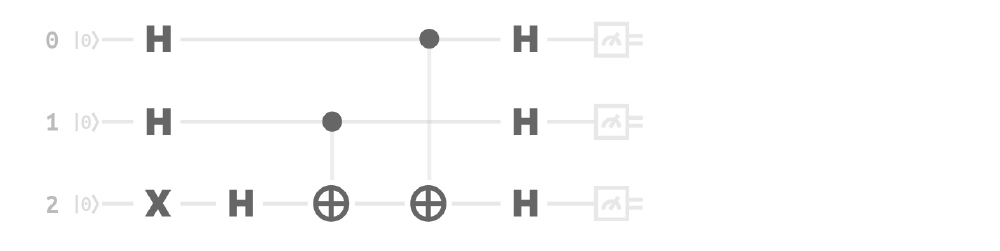

- In first step we initialize the circuit with 2 qubits in `|0⟩` state and an extra ancilla qubit in `|1⟩` state by apply Pauli-X (NOT) gate on it. 
- Then we apply Hadamard gate on all these initialized qubits which generates superpostion for `|0⟩` qubits as $\frac{1}{\sqrt{2}}(|0⟩ + |1⟩)$ and for the ancilla qubit as $\frac{1}{\sqrt{2}}(|0⟩ - |1⟩)$.
- Then we apply our oracle function, where we use pairs of CNOT gates wherever our bit is 1 in the secret string acting as control bit and ancilla qubit acting as target bit. Applying the CNOT operation and taking the tensor product of these qubit gives us the subsequently change the state of our control bit, retrieving all the bits in secret string having bit as 1. 
- We then retrieve the target string by using Hadamard gates on these qubits.

Since this implementation necessitates entangling as many as all of the qubits in the register with the ancilla qubit, and successfully performing multiple single-qubit rotations on each qubit, it also serves a reasonable test of quantum computer perfomance, where we can generally expect systems with more complete connectivity to outperform ones with more restricted connectivity, because the additional `SWAP` overhead required to make all of the input qubits 'talk' to the ancilla will introduce additonal noise into the computation. 

Now, let's implement in code using the Braket SDK.

## Imports and Setup

First, we'll do some setup that will allow us to build, visualize, store, and retrieve the circuits we'll be running via the Braket SDK.

In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import math
import time

# magic invocation for producing visualizations in notebook
%matplotlib inline

In [2]:
# AWS imports: Import Braket SDK modules
import boto3
from braket.circuits import circuit, Circuit, Gate, Moments
from braket.circuits.instruction import Instruction
from braket.devices import LocalSimulator
from braket.aws import AwsQuantumTask, AwsDevice

In [3]:
# set up S3 bucket (where results are stored). Change the bucket_name to the S3 bucket you created.
aws_account_id = boto3.client("sts").get_caller_identity()["Account"]
my_bucket = "amazon-braket-Your-Bucket-Name" # the name of the bucket
my_prefix = "Your-Folder-Name" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

## Building the Circuit

Rather than manually building the BV circuit every time, we'll create a method that can build one for any $s$ and any register size.

In [4]:
def make_bv_circuit(s_int, input_size):
    """build the Bernstein-Vazirani circuit
     
    Args:
        s_int (int): value of s as an integer
        input_size (int): size of the input register, 
            i.e. the number of (qu)bits to use for the binary 
            representation of s

    Returns:
        circ (obj): the completed BV circuit

    """
    # confirm the bitstring of S is what we think it should be
    s=('{0:0' + str(input_size) + 'b}').format(s_int)
    print('s:', s)
    
    circ = Circuit()
    # put ancilla in state |-⟩
    circ.x(input_size)
    
    # apply a Hadamard to every qubit before querying the oracle
    for i_qubit in range(input_size+1):
        circ.h(i_qubit)        

    # apply our oracle as a series of cnot gates
    for bit in range(input_size):
        if s[bit]=='1':
            circ.cnot(bit, input_size)
    
    # add Hadamard gates again after querying the oracle
    for i_qubit in range(input_size+1):
        circ.h(i_qubit)
    
    return circ 

We can now build a BV circuit of any size. As an example, let's start with a small problem with the target bitstring 101, i.e integer as 5. For this example, four qubits (an input size of three plus one ancilla) are needed to find the target bitstring using the BV algorithm. 

In [5]:
# make the circuit
s_int = 5
input_size = len(bin(s_int)[2:])
bv5 = make_bv_circuit(s_int, input_size)

# print the circuit to confirm it was built as expected
print(bv5)

s: 101
T  : |0|1|2|3|4|
                
q0 : -H---C-H---
          |     
q1 : -H-H-|-----
          |     
q2 : -H---|-C-H-
          | |   
q3 : -X-H-X-X-H-

T  : |0|1|2|3|4|


## Running the circuit on the local simulator

Now, let's run our circuit using the local simulator. It's useful to first test a small version on a simulator before running it on the actual quantum device, to make sure it's behaving as expected. For fast experiments with low-to-intermediate qubit numbers ($N<20-25$), the local simulator is the preferred choice.

In [6]:
# set up device: Local Simulator.
device = LocalSimulator()

By default, the circuit will only return its results as counts. If we want to see probabilities or the full state vector (the state vector is only available from the local simulator), we must append the desired result types before running the circuit.

With a larger qubit register, printing the full probability distribution can become overwhelming, and it's often bettter to just show the distribution of nonzero output strings, but we'll show how to do it here while we're dealing with only 16 possible output strings. 

In [7]:
# append the probability result type
bv5.probability();

In [8]:
# run the circuit
result = device.run(bv5, shots=1000).result()
# get measurment counts
counts = result.measurement_counts
# print counts
print('counts:', counts)

counts: Counter({'1011': 1000})


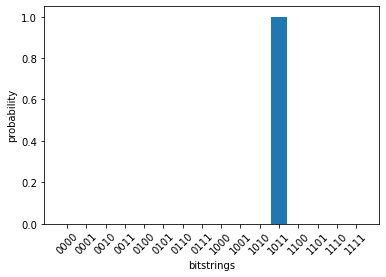

In [9]:
# set up values for plot
num_qubits = bv5.qubit_count
format_bitstring = '{0:0' + str(num_qubits) + 'b}'
bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]
probabilities = result.values[0]

# plot full probability distribution
plt.bar(bitstring_keys, probabilities);
plt.xlabel('bitstrings');
plt.ylabel('probability');
plt.xticks(rotation=45);

## Running the circuit on the managed simulator

We also have the option of running our circuit on the managed simulator. This is ideal for large simulation jobs (jobs with many highly-entangled qubits) where memory-optimized cloud hardware will be more performant than a local machine. 

Here, the `run()` method must also include an S3 location where the result will be stored. This is the `s3_folder` we initialized at the top of the notebook.

In [10]:
# set up device
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

In [11]:
# define a larger BV circuit
s_int = 999
input_size = len(bin(s_int)[2:])
bv999 = make_bv_circuit(s_int, input_size)

# visualize the circuit
print(bv999)

s: 1111100111
T   : |0|1|2|3|4|5|6|7|8|9|10|
                              
q0  : -H---C-H----------------
           |                  
q1  : -H---|-C-H--------------
           | |                
q2  : -H---|-|-C-H------------
           | | |              
q3  : -H---|-|-|-C-H----------
           | | | |            
q4  : -H---|-|-|-|-C-H--------
           | | | | |          
q5  : -H-H-|-|-|-|-|----------
           | | | | |          
q6  : -H-H-|-|-|-|-|----------
           | | | | |          
q7  : -H---|-|-|-|-|-C-H------
           | | | | | |        
q8  : -H---|-|-|-|-|-|-C-H----
           | | | | | | |      
q9  : -H---|-|-|-|-|-|-|-C-H--
           | | | | | | | |    
q10 : -X-H-X-X-X-X-X-X-X-X-H--

T   : |0|1|2|3|4|5|6|7|8|9|10|


In [12]:
# run BV circuit on the managed simulator
simulator_job = device.run(bv999, s3_folder, shots=1000, poll_timeout_seconds=24*60*60)

Because the managed simulator is a remote resource, it may take a short while for our job to complete. We can request its status from the SDK, and once we see that it's finished, proceed to examine the results.

In [13]:
# Get ID of job
simulator_job_id = simulator_job.id
print('Job ID :', simulator_job_id)

# Wait for job to complete
status_list = []
status = simulator_job.state()
status_list += [status]
print('Status:', status)

# Print when there's a status change until job is completed
while status != 'COMPLETED':
    time.sleep(1) # wait a second at the top of each loop so we're not hammering the API
    status = simulator_job.state()
    if status != status_list[-1]:
        print('Status:', status)
    status_list += [status]

Job ID : arn:aws:braket:us-west-2:984631112496:quantum-task/29ab3f06-cdde-4c93-a6bd-3966e9eaea93
Status: QUEUED
Status: RUNNING
Status: COMPLETED


Once our job is completed, we can examine and plot (or otherwise post-process) the results as desired.

Counter({'11111001111': 1000})


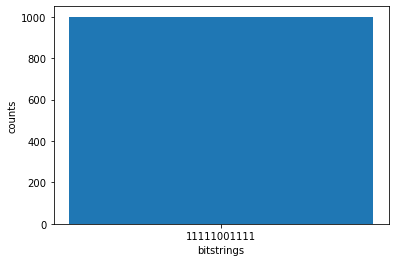

In [14]:
counts = simulator_job.result().measurement_counts
print(counts)

# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

## Quantum Hardware: IonQ

Now let's try running our circuit on real quantum hardware. We will be using the ion-based quantum machine provided by IonQ. Because we're limited by hardware availaility, our job may not run immediately, and may instead be queued to run on this device at some point in the future. While we may have to wait for some time for our circuit to be run, asynchronous execution allows us to perform other tasks and come back later to check its status, rather than being blocked until it's executed. 

In [15]:
# set up device
ionq = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")

# run circuit with a polling time of 5 days
ionq_job = ionq.run(bv999, s3_folder, shots=100, poll_timeout_seconds=5*24*60*60)

# get id and status of submitted task
ionq_job_id = ionq_job.id
ionq_job_status = ionq_job.state()

print('Job ID:', ionq_job_id)
print('Job status:', ionq_job_status)

Job ID: arn:aws:braket:us-east-1:984631112496:quantum-task/cd3aa3c8-3664-46b3-8278-a3482462da98
Job status: CREATED


Now that the job has been created, we can check its status by running the below cell (re-running the above cell would submit an entirely new job). See below for examples of logic for proceed with further analysis and visualization once the job is complete.

In [17]:
# get id and status of submitted task
ionq_job_id = ionq_job.id
ionq_job_status = ionq_job.state()

print('Job ID:', ionq_job_id)
print('Current status:', ionq_job_status)

Job ID: arn:aws:braket:us-east-1:984631112496:quantum-task/cd3aa3c8-3664-46b3-8278-a3482462da98
Current status: QUEUED


## Retrieving Jobs

Once the job has been submitted, you can retrieve its status and, if it has been run, its results and other metadata using its unique job ID. First, let's create a helper method to retrieve and print the details of any job we have the ID for.

In [18]:
def retrieve_job(job_id):
    """retrieves job and graphs output and metadata if completed
    Args:
        job_id (str): the job ID (arn) we wish to retrieve

    Returns:
        retrieved (obj): the recovered job
    """
    # recover task
    retrieved = AwsQuantumTask(arn=job_id)

    # check status
    status = retrieved.state()
    print('Status of retrieved job:', status)

    # wait for job to complete
    # terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
    if status == 'COMPLETED':
        # get results
        results = retrieved.result()
        # print(results)

        # get all metadata
        metadata = retrieved.metadata()
        # example for metadata
        shots = metadata['shots']
        machine = metadata['deviceArn']
        # print example metadata
        print("{} shots taken on machine {}.\n".format(shots, machine))

        # get measurement counts
        counts = results.measurement_counts
        print('Measurement counts:', counts)

        # plot results: see algorithm accuracy
        plt.bar(counts.keys(), counts.values());
        plt.xlabel('bitstrings');
        plt.ylabel('counts');
        plt.xticks(rotation=45);
        plt.tight_layout();
    
        return retrieved
                
    elif status in ['FAILED', 'CANCELLED']:
        # print terminal message 
        print('Your job has either failed or been cancelled.')

    else:
        # print current status
        print('Sorry, your job is still being processed. Try again later.')

Next, let's retrieve the results from the IonQ system.

Status of retrieved job: COMPLETED
100 shots taken on machine arn:aws:braket:::device/qpu/ionq/ionQdevice.

Measurement counts: Counter({'11111001111': 79, '11111001101': 7, '11101001111': 3, '11000000000': 2, '10000000000': 1, '11111001100': 1, '10111000101': 1, '11101001101': 1, '10111001101': 1, '11111001011': 1, '10011000111': 1, '11011001111': 1, '01111001111': 1})


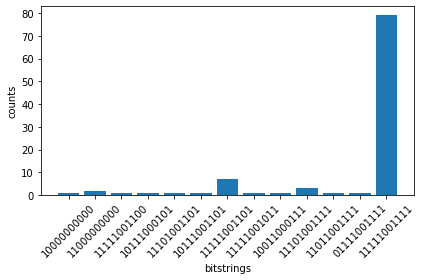

In [40]:
retrieved_ionq = retrieve_job(ionq_job_id)

The accuracy of the quantum computer for this algorithm corresponds to the number of shots for the ideal bitstring—the input bitstring appended with a 1 from the ancilla qubit—divided by the total number of shots. We can find out how each system did by comparing it to our simulation results, which returned the ideal bitstring 100% of the time. We'll use the probability output so that we don't need to worry about scaling to different shot counts. 
If we look at the IonQ results, we can see that there is some noise in the measurements, but we still correctly identify the secret binary string with high accuracy. 

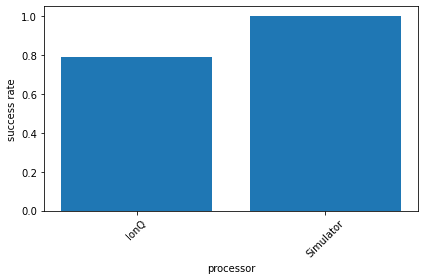

In [42]:
if retrieved_ionq != None:
    ionq_probabilities = retrieved_ionq.result().measurement_probabilities
    simulator_probabilities = simulator_job.result().measurement_probabilities

    def safe_lookup(d, k):
        """gets value at key, catches KeyError and returns zero if doesn't exist in dict
        Args:
            d: the dict to look in
            k: the key to look for 
        Returns:
            lookup: item in question, or zero if key doesn't exist
        """
        try:
            lookup = d[k]
        except KeyError:
            lookup = 0
        return lookup

    ideal_bitstring = '11111001111'

    processors = ['IonQ', 'Simulator']

    success_rates = [ safe_lookup(ionq_probabilities, ideal_bitstring), safe_lookup(simulator_probabilities, ideal_bitstring)]
    x_pos = [i for i, _ in enumerate(processors)]

    plt.bar(x_pos, success_rates);
    plt.xlabel('processor');
    plt.ylabel('success rate');
    plt.xticks(x_pos, processors, rotation=45);
    plt.tight_layout();
else:
    print("Sorry, your job is still being processed. Try again later.")

In terms of performance, while quantum computers might not be as accurate as classical simulations. We can still ascertain that quantum algorithms can find a hidden string of any length in O(1), while classical algorithms require O(N) time. In summary, we have shown how to implement Bernstein Vazirani algorithm on a classical simulator, as well as on the IonQ device, using simple modular building blocks. 